In [ ]:
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

import pandas as pd # импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np # Импортируем библиотеку numpy
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE
import time
import os

from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist

In [ ]:
# Загрузим данные
(x_train, y_train), (_, _) = mnist.load_data()
X = x_train.astype(np.float32)/255.
X = np.expand_dims(X, -1)
X.shape, X.dtype

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), dtype('float32'))

In [ ]:
# Используем автоэнкодер как модель
def Autoencoder(shape=(28, 28, 1), latent_dim=100): 
    img_input = Input((shape)) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)  
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 
    x = Flatten()(x)
    
    z = Dense(latent_dim, name="latent_space")(x)

    x = Dense(7*7*128)(z)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    out = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, out) 
    encoder = Model(img_input, z)

    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error') 

    return model, encoder

In [ ]:
# Создадим модель
model, enc = Autoencoder((28, 28, 1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256   

In [ ]:
# Обучим модель
history = model.fit(X, X, epochs=10, batch_size=100, validation_split=0.1)

Epoch 1/10
540/540 [==============================] - 13s 22ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 2/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 3/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 4/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 5/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 8/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 9/10
540/540 [==============================] - 12s 21ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/10
540/540 [==============================] - 12s 22ms/step - loss: 0.001

In [ ]:
# Предикт модели
pred = model.predict(X)
pred

array([[[[0.00405986],
         [0.00278948],
         [0.00162856],
         ...,
         [0.00313752],
         [0.00298142],
         [0.00524904]],

        [[0.00355049],
         [0.00201078],
         [0.00123975],
         ...,
         [0.00278132],
         [0.00235026],
         [0.00481569]],

        [[0.00199587],
         [0.00188202],
         [0.00173148],
         ...,
         [0.00284584],
         [0.00314161],
         [0.0023365 ]],

        ...,

        [[0.00421174],
         [0.00279944],
         [0.00862923],
         ...,
         [0.00284888],
         [0.00293915],
         [0.00399735]],

        [[0.00151455],
         [0.00262238],
         [0.00893444],
         ...,
         [0.00280825],
         [0.00214617],
         [0.00327364]],

        [[0.00472661],
         [0.00369798],
         [0.00631344],
         ...,
         [0.00299264],
         [0.00288021],
         [0.00594204]]],


       [[[0.00335928],
         [0.00253012],
         [0.00

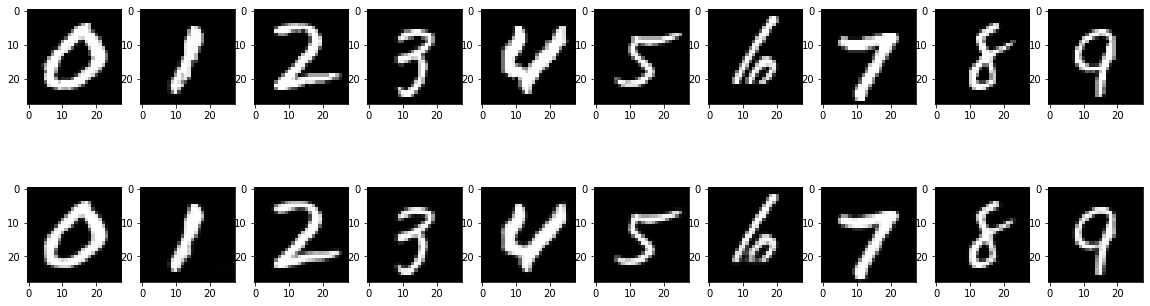

In [ ]:
plt.figure(figsize=(20,6))
shift = np.random.randint(1000)
for i in range(10):
    plt.subplot(2, 10, 1+i)
    plt.imshow(X[y_train == i][shift].reshape(28,28), cmap='gray')
    plt.subplot(2, 10, 11+i)
    plt.imshow(pred[y_train == i][shift].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
z_train = enc.predict(X)
z_train.shape, z_train.std()

((60000, 100), 6.485273)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


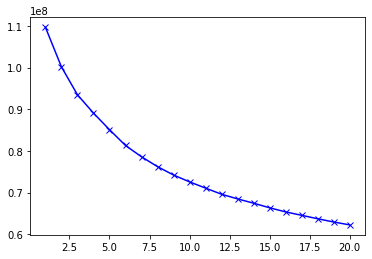

CPU times: user 6min 38s, sys: 7min 58s, total: 14min 37s
Wall time: 6min 27s


In [ ]:
# Изобразим граффик кластеров
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters+1): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(z_train)   # Проводим кластеризацию z_train
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters+1)], cost, 'bx-')
plt.show()

In [ ]:
# Кластеризация Метрика homogeneity_score 
km = KMeans(10)
km.fit(z_train)

pred = km.predict(z_train)
print(homogeneity_score(y_train, pred))

0.5317741615174435


In [ ]:
# Помения параметры dim=12
model_1, enc_1 = Autoencoder((28, 28, 1), latent_dim=12)


In [ ]:
history = model_1.fit(X, X, epochs=20, batch_size=300, validation_split=0.1)


Epoch 1/20
180/180 [==============================] - 11s 54ms/step - loss: 0.1299 - val_loss: 0.1025
Epoch 2/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0477 - val_loss: 0.0982
Epoch 3/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0364 - val_loss: 0.0449
Epoch 4/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0255 - val_loss: 0.0240
Epoch 5/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0232 - val_loss: 0.0243
Epoch 6/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0220 - val_loss: 0.0230
Epoch 7/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 8/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0200 - val_loss: 0.0203
Epoch 9/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0193 - val_loss: 0.0186
Epoch 10/20
180/180 [==============================] - 9s 51ms/step - loss: 0.0151 - val_l

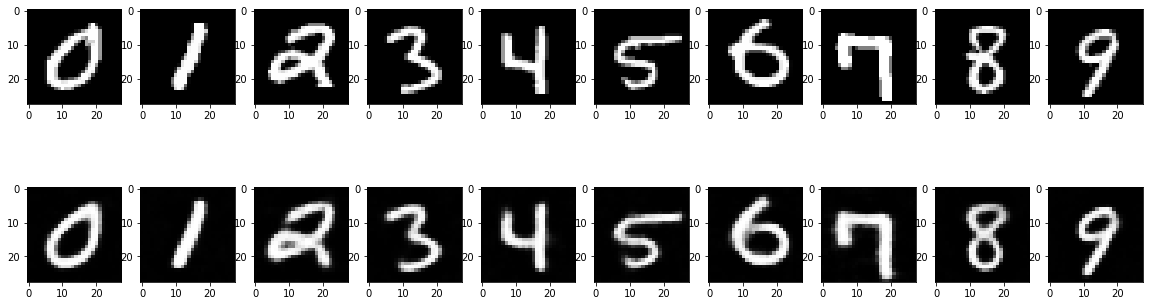

In [ ]:
pred = model_1.predict(X)

plt.figure(figsize=(20,6))
shift = np.random.randint(1000)
for i in range(10):
    plt.subplot(2, 10, 1+i)
    plt.imshow(X[y_train == i][shift].reshape(28,28), cmap='gray')
    plt.subplot(2, 10, 11+i)
    plt.imshow(pred[y_train == i][shift].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
z_train3 = enc_1.predict(X)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 


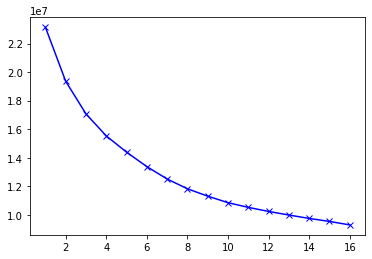

CPU times: user 1min 2s, sys: 57.2 s, total: 1min 59s
Wall time: 58 s


In [ ]:
%%time
n_clusters = 16               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters+1): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(z_train3)   # Проводим кластеризацию z_train
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters+1)], cost, 'bx-')
plt.show()

In [ ]:
# Кластеризация Метрика homogeneity_score 
km = KMeans(10)
km.fit(z_train3)

pred = km.predict(z_train3)
print(homogeneity_score(y_train, pred))

0.6713215247659858
